In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

RAW_DATA_PATH = '../data/raw'

file_names = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

## Verificação de Integridade

In [2]:
print("--- INICIANDO VERIFICAÇÃO DE INTEGRIDADE DOS DADOS ---")

# --- Loop de Verificação ---
for file in file_names:
    file_path = os.path.join(RAW_DATA_PATH, file)
    
    print(f"\n=======================================================")
    print(f"Arquivo: {file}")
    print(f"=======================================================")
    
    try:
        df = pd.read_csv(file_path)
        
        print(f"Dimensões: {df.shape[0]} linhas e {df.shape[1]} colunas.")
        
        print("\nTipos de Dados e Nulos (Resumo):")
        # buffer para capturar a saída do .info()
        import io
        buffer = io.StringIO()
        df.info(buf=buffer)
        print(buffer.getvalue())
        
        # Contagem Detalhada de Nulos (em porcentagem)
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        missing_df = pd.DataFrame({'count': missing_values, 'percentage': missing_percentage})
        missing_df = missing_df[missing_df['count'] > 0].sort_values(by='percentage', ascending=False)
        
        if not missing_df.empty:
            print("\nPercentual de Valores Ausentes por Coluna:")
            print(missing_df)
        else:
            print("\nNenhum valor ausente encontrado.")

        # Linhas Duplicadas
        num_duplicates = df.duplicated().sum()
        if num_duplicates > 0:
            print(f"\nAlerta: Encontradas {num_duplicates} linhas duplicadas.")
        else:
            print("\nNenhuma linha duplicada encontrada.")
            
        # Primeiras Linhas
        print("\nPrimeiras 3 Linhas do Dataset:")
        print(df.head(3))
        
    except FileNotFoundError:
        print(f"Erro: O arquivo {file} não foi encontrado no caminho especificado.")
    except Exception as e:
        print(f"Ocorreu um erro ao processar o arquivo {file}: {e}")

print("\n--- VERIFICAÇÃO DE INTEGRIDADE CONCLUÍDA ---")

--- INICIANDO VERIFICAÇÃO DE INTEGRIDADE DOS DADOS ---

Arquivo: olist_customers_dataset.csv
Dimensões: 99441 linhas e 5 colunas.

Tipos de Dados e Nulos (Resumo):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Nenhum valor ausente encontrado.

Nenhuma linha duplicada encontrada.

Primeiras 3 Linhas do Dataset:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7

### Análise dos resultados da verificação
#### Qualidade Geral
Após a verificação, podemos notar que a maioria dos datasets está sem valores nulos ou duplicados. Podemos confiar na integridade das chaves primárias e estrangeiras.
#### Pontos de Atenção da verificação
##### Arquivo `olist_orders_dataset.csv` (Valores Nulos em Datas)

Encontramos valores nulos nas colunas de data que rastreiam o progresso da entrega:
- `order_delivered_customer_date` (2.98% nulos)
- `order_delivered_carrier_date` (1.79% nulos)
- `order_approved_at` (0.16% nulos)

Após análise na descrição do dataset, chega-se a conclusão de que estes nulos correspondem ao estado de **pedido não entregue** (ex: foi cancelado ou estava em trânsito no fim da coleta).

**Ações**
Para a criação da variável alvo `atrasado`, precisamos dos pedidos que foram efetivamente entregues. Portanto, na fase de preparação de dados, teremos que filtrar o dataset, mantendo apenas as linhas onde `order_delivered_customer_date` não é nulo. Os pedidos cancelados ou em trânsito não são úteis para treinar um modelo que prevê atraso na entrega.

##### Arquivo `olist_order_reviews_dataset.csv` (Valores Nulos em Comentários)
A maioria dos clientes apenas dá uma nota (review_score) sem se dar ao trabalho de escrever um comentário: `review_comment_title` (88% nulos) e `review_comment_message` (58% nulos).

**Ações**

O escopo do projeto não abrange PLN (Processamento de Linguagem Natural) portanto podemos ignorar ou remover as colunas.

##### Arquivo `olist_products_dataset.csv` (Valores Nulos)
Temos ~1.85% de nulos em colunas importantes como `product_category_name` e nas dimensões/peso.

**Ações**

Opções de tratamento para a fase de limpeza (a decidir):
1. **Imputação Simples**: Preencher os valores numéricos (peso, etc.) com a mediana da sua categoria
2. **Imputação Categórica**: Criar uma categoria chamada "desconhecida" para product_category_name.
3. **Remoção**: Dado o baixo percentual, a remoção das linhas com dados faltantes também é uma opção viável.

##### Arquivo `olist_geolocation_dataset.csv` (Linhas Duplicadas)
Apresenta 261.831 linhas duplicadas. Existem múltiplas coordenadas de latitude/longitude muitas mínimas para o mesmo prefixo de CEP. Isso pode ocorrer porque um prefixo de CEP pode abrange uma área.

**Ações**

Iremos considerar a média de todas as coordenadas de determinado CEP para para representação em `geolocation_zip_code_prefix`.

##### Tipos de Dados (Dtypes)
Todas as colunas de data/hora (timestamp, date) foram carregadas como object (strings).

**Ações**
Na fase de preparação, será essencial converter todas essas colunas para o tipo `datetime` usando `pd.to_datetime`.



## Análise exploratória
O objetivo desta etapa é entender a distribuição e o comportamento das variáveis de negócio mais críticas. Observam-se os três datasets que formam o coração do ciclo de vida de uma transação: orders (o que aconteceu com o pedido), payments (como ele foi pago) e reviews (qual foi o resultado da experiência do cliente).

**Perguntas as serem respondidas:**
- **Reviews:** Qual é a distribuição das notas de avaliação? A maioria dos clientes está satisfeita ou insatisfeita?
- **Payments:** Quais são as formas de pagamento mais comuns? Como se distribuem os valores dos pagamentos e o número de parcelas?
- **Orders:** Como as vendas se distribuem ao longo do tempo (anos, meses, dias da semana)? Qual é o status mais comum dos pedidos?

### Parte 1: Datasets de Pedidos, Pagamentos e Reviews.

DataFrames carregados e colunas de data convertidas com sucesso.

### 1. Análise de Satisfação do Cliente (Reviews) ###


/tmp/ipykernel_5460/1566142395.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='review_score', data=df_reviews, palette='viridis')


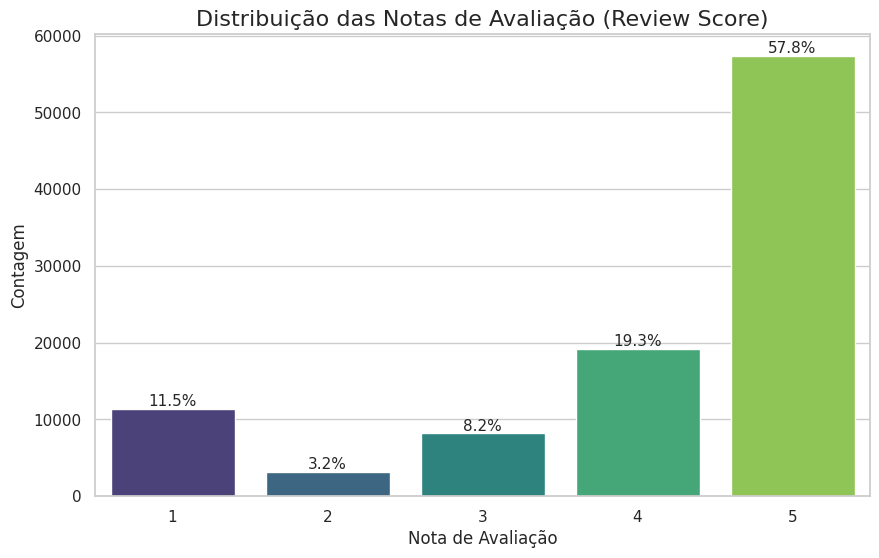

In [3]:
sns.set_theme(style="whitegrid")

try:
    df_reviews = pd.read_csv(os.path.join(RAW_DATA_PATH, 'olist_order_reviews_dataset.csv'))
    df_payments = pd.read_csv(os.path.join(RAW_DATA_PATH, 'olist_order_payments_dataset.csv'))
    df_orders = pd.read_csv(os.path.join(RAW_DATA_PATH, 'olist_orders_dataset.csv'))
    
    # Conversão de tipos de dados
    date_columns = [
        'order_purchase_timestamp', 'order_approved_at', 
        'order_delivered_carrier_date', 'order_delivered_customer_date', 
        'order_estimated_delivery_date'
    ]
    for col in date_columns:
        df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce') # 'coerce' transforma erros em NaT
        
    print("DataFrames carregados e colunas de data convertidas com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}. Verifique o caminho e os nomes dos arquivos.")


print("\n### 1. Análise de Satisfação do Cliente (Reviews) ###")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='review_score', data=df_reviews, palette='viridis')
ax.set_title('Distribuição das Notas de Avaliação (Review Score)', fontsize=16)
ax.set_xlabel('Nota de Avaliação', fontsize=12)
ax.set_ylabel('Contagem', fontsize=12)
# percentual em cima das barras
total = len(df_reviews)
for p in ax.patches:
    percentage = f'{(p.get_height()/total)*100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=11)
plt.show()

#### Sobre as Avaliações
- **Observações:** A maioria das avaliações é positiva (57.8% de 5 estrelas e 19.3% de 4 estrelas), mas há um grupo significativo de clientes muito insatisfeitos (11.5% de 1 estrela).
- **Interpretações:** A Olist consegue, na maioria das vezes, entregar uma boa experiência. No entanto, a cauda de 1 estrela (11.5%) é um ponto crítico de atenção. Em e-commerce, clientes muito insatisfeitos são os que mais geram ruído negativo e custos de atendimento. Entender a causa raiz desse grupo é fundamental para a saúde do negócio.
- **Hipóteses:** 
    - A grande maioria das avaliações de 1 estrela está correlacionada com atrasos significativos na entrega. 
        - Esta é a principal hipótese que nosso modelo preditivo e análises posteriores tentarão confirmar ou refutar.


### 2. Análise de Pagamentos ###


/tmp/ipykernel_5460/1356836266.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='payment_type', data=df_payments, order=df_payments['payment_type'].value_counts().index, palette='plasma')


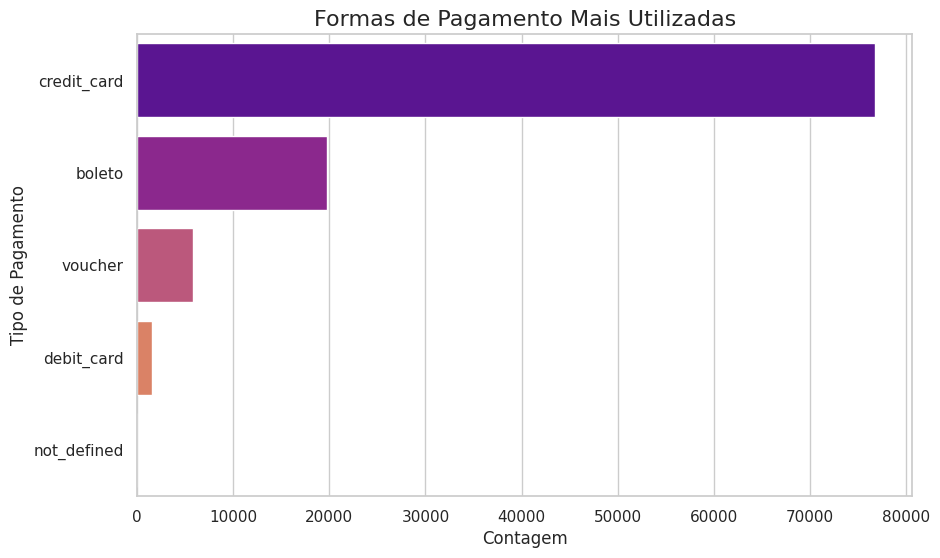

/tmp/ipykernel_5460/1356836266.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='payment_installments', data=df_credit_card, palette='magma')


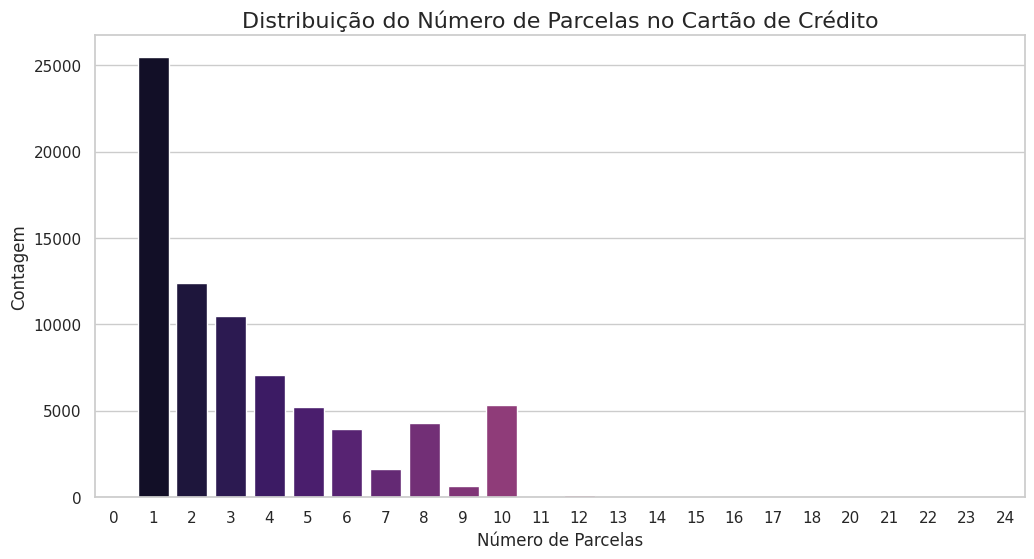

In [4]:
print("\n### 2. Análise de Pagamentos ###")

plt.figure(figsize=(10, 6))
ax = sns.countplot(y='payment_type', data=df_payments, order=df_payments['payment_type'].value_counts().index, palette='plasma')
ax.set_title('Formas de Pagamento Mais Utilizadas', fontsize=16)
ax.set_xlabel('Contagem', fontsize=12)
ax.set_ylabel('Tipo de Pagamento', fontsize=12)
plt.show()

# parcelas para "credit_card"
df_credit_card = df_payments[df_payments['payment_type'] == 'credit_card']
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='payment_installments', data=df_credit_card, palette='magma')
ax.set_title('Distribuição do Número de Parcelas no Cartão de Crédito', fontsize=16)
ax.set_xlabel('Número de Parcelas', fontsize=12)
ax.set_ylabel('Contagem', fontsize=12)
plt.show()



### 2. Análise de Pagamentos ###


/tmp/ipykernel_5460/913552013.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='payment_type', data=df_payments, order=df_payments['payment_type'].value_counts().index, palette='plasma')


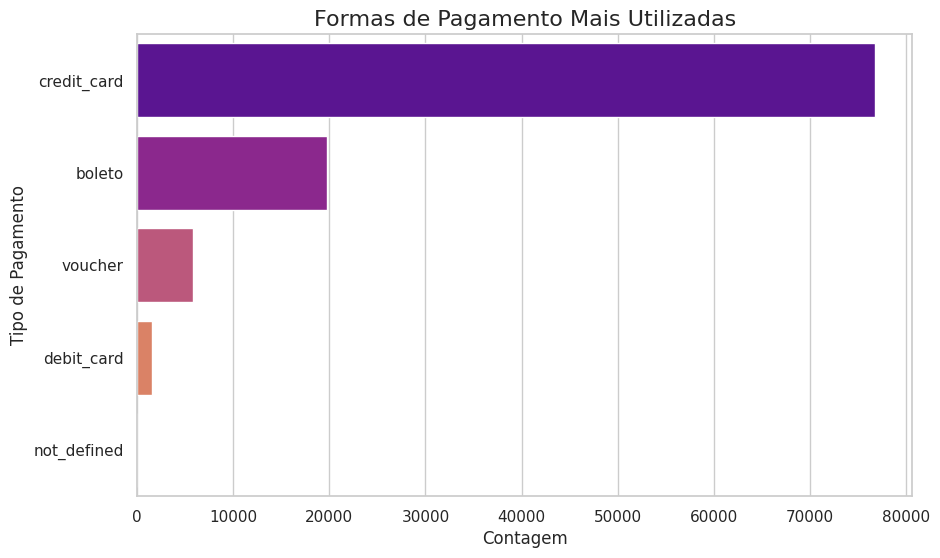

/tmp/ipykernel_5460/913552013.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


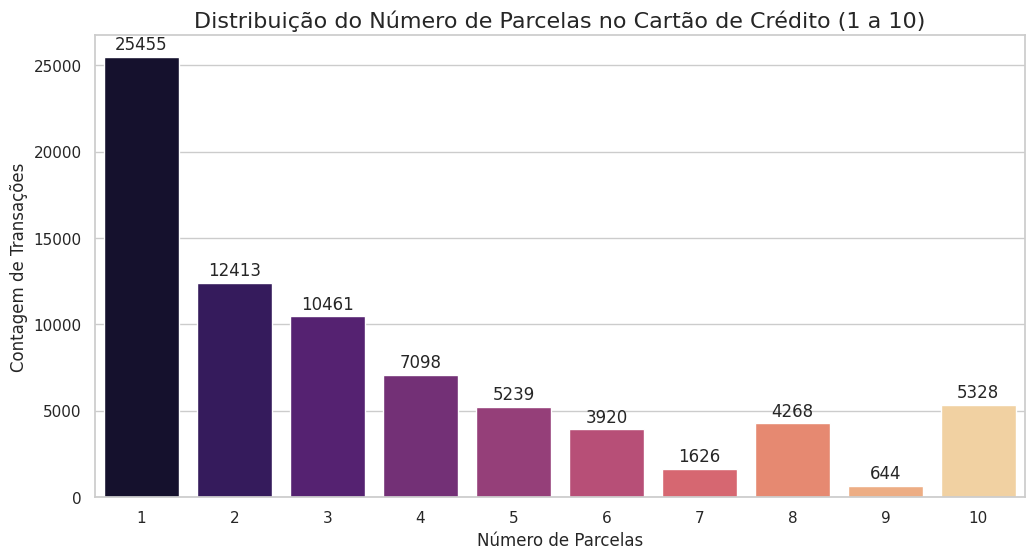

In [5]:
print("\n### 2. Análise de Pagamentos ###")

plt.figure(figsize=(10, 6))
ax = sns.countplot(y='payment_type', data=df_payments, order=df_payments['payment_type'].value_counts().index, palette='plasma')
ax.set_title('Formas de Pagamento Mais Utilizadas', fontsize=16)
ax.set_xlabel('Contagem', fontsize=12)
ax.set_ylabel('Tipo de Pagamento', fontsize=12)
plt.show()


# 1. pagamentos com cartão de crédito
df_credit_card = df_payments[df_payments['payment_type'] == 'credit_card']

# 2. número de parcelas para o intervalo de 1 a 10 
df_installments_filtered = df_credit_card[
    (df_credit_card['payment_installments'] >= 1) & 
    (df_credit_card['payment_installments'] <= 10)
]

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='payment_installments', 
    data=df_installments_filtered, 
    palette='magma',
    order=range(1, 11) # eixo x  ordenado de 1 a 10
)
ax.set_title('Distribuição do Número de Parcelas no Cartão de Crédito (1 a 10)', fontsize=16)
ax.set_xlabel('Número de Parcelas', fontsize=12)
ax.set_ylabel('Contagem de Transações', fontsize=12)

# rótulos de contagem em cima das barras para clareza
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
plt.show()

#### Sobre as Formas de Pagamento
- **Observações:** `credit_card` e `boleto` dominam. `voucher` é relevante, e `not_defined` não existe, o que indica dados limpos.
- **Interpretações:** 
    - Pode indicar um comportamento típico do e-commerce brasileiro. A oferta de crédito (parcelamento) é um grande impulsionador de vendas, enquanto o boleto é essencial para incluir clientes sem cartão.
    - `voucher` pode indicar o sucesso de campanhas de marketing, parcerias ou programas de fidelidade.
- **Hipóteses:** 
    - Pedidos pagos com boleto demoram mais para serem aprovados (`order_approved_at`) do que os de `credit_card`, o que pode ser um fator contribuinte para o tempo total de entrega.

#### Sobre o Número de Parcelas
- **Observações:** A distribuição decai, mas há picos anômalos e massivos em 8 e 10 parcelas.
- **Interpretações:** 
    - Isso não é um comportamento orgânico do consumidor. É quase certo que isso reflete uma estratégia de negócio ou uma promoção específica da Olist ou de seus parceiros.
    - É muito provável que houvesse campanhas de "Pague em até 10x sem juros" ou que produtos de um certo valor tivessem essas opções de parcelamento como padrão. Os picos em 8 e 10 parcelas podem estar atrelados a faixas de preço específicas.
- **Hipóteses:** 
    - Os picos de 8 e 10 parcelas estão associados a produtos de maior valor (`price`).


### 3. Análise de Pedidos (Orders) ###


/tmp/ipykernel_5460/3346100063.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='order_status', data=df_orders, order=df_orders['order_status'].value_counts().index, palette='cividis')


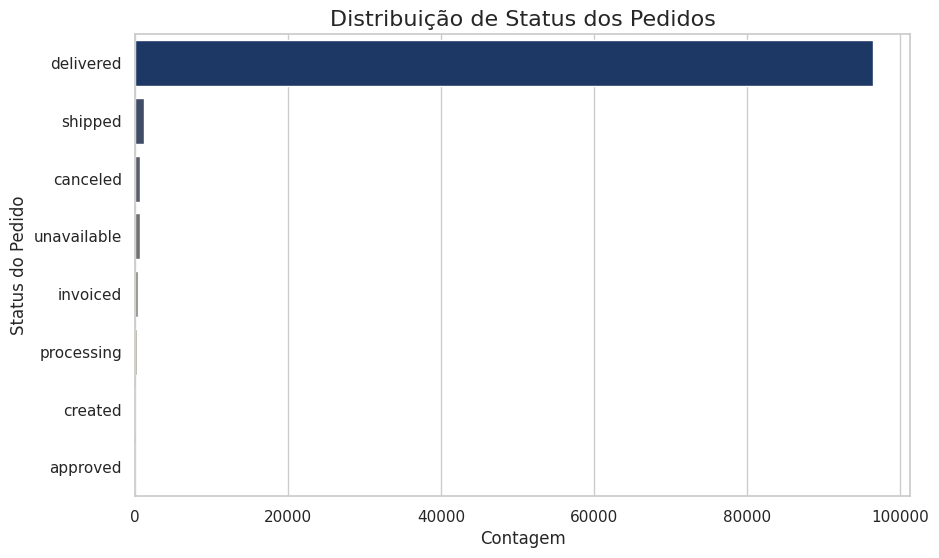

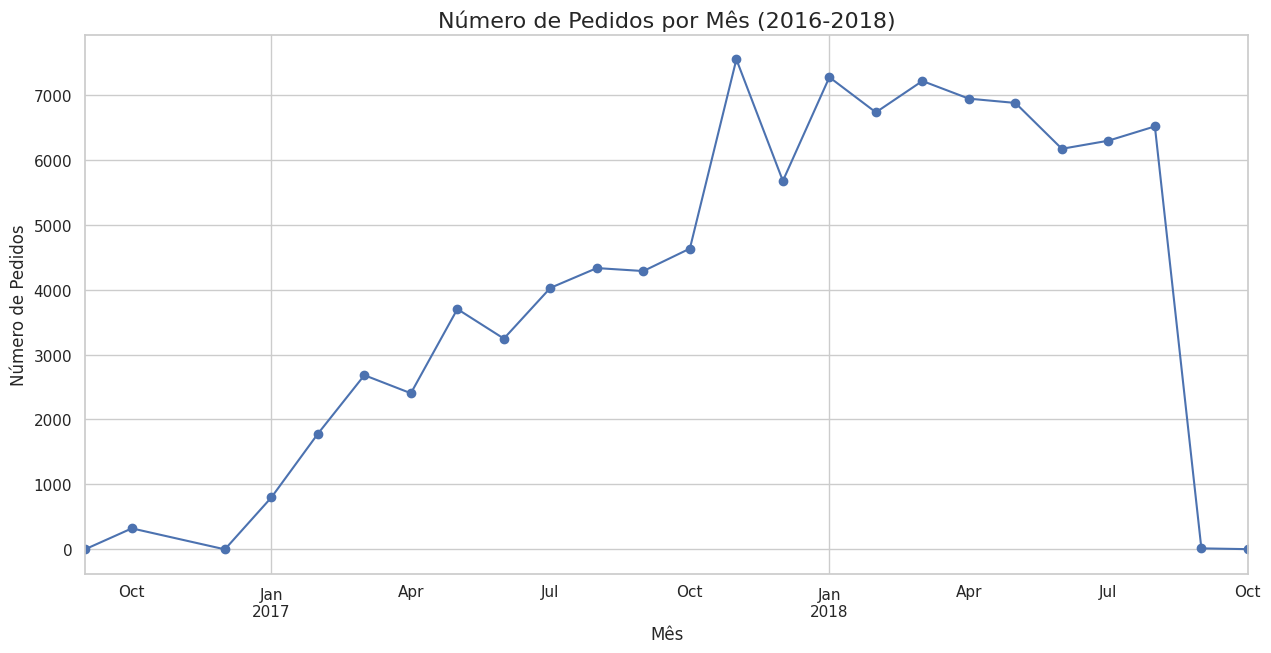

In [6]:
print("\n### 3. Análise de Pedidos (Orders) ###")

# status dos pedidos
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='order_status', data=df_orders, order=df_orders['order_status'].value_counts().index, palette='cividis')
ax.set_title('Distribuição de Status dos Pedidos', fontsize=16)
ax.set_xlabel('Contagem', fontsize=12)
ax.set_ylabel('Status do Pedido', fontsize=12)
plt.show()

# Vendas por Mês - Extraindo o mês e ano da data de compra
df_orders['purchase_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')

monthly_orders = df_orders['purchase_month'].value_counts().sort_index()

plt.figure(figsize=(15, 7))
monthly_orders.plot(kind='line', marker='o')
plt.title('Número de Pedidos por Mês (2016-2018)', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.grid(True)
plt.show()

#### Sobre o Número de Pedidos por Mês
- **Observações:** Crescimento até um pico em Nov/2017, seguido por estabilização. E, a presença de meses com zero pedidos.
- **Interpretações:** 
    - A curva de crescimento até o final de 2017 mostra uma empresa em rápida expansão. A estabilização em 2018 pode indicar que o negócio atingiu um novo patamar de maturidade.
    - Os meses com zero elementos indicam lacunas na coleta de dados. O dataset não é um registro contínuo de todos os dias de 2016 a 2018.
- **Ações:** 
    - A análise deve se concentrar no período de dados mais robusto e contínuo (aproximadamente de Jan/2017 a Ago/2018), e precisamos estar cientes das lacunas existentes.